## Stock Price Prediction using ARIMA model

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import datetime
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
# Importing the yfinance package
import yfinance as yf

# Set the start and end date
start_date = '2020-01-01'
end_date = '2023-08-30'

# Set the ticker
ticker = 'GOOGL'

# Get the data
stock_data = yf.download(ticker, start_date, end_date)

# Print the last 5 rows
print(stock_data.tail())

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-23  130.179993  133.410004  129.869995  132.369995  132.369995   
2023-08-24  133.949997  134.250000  129.570007  129.779999  129.779999   
2023-08-25  129.539993  130.759995  127.250000  129.880005  129.880005   
2023-08-28  131.309998  132.539993  130.139999  131.009995  131.009995   
2023-08-29  132.240005  136.570007  132.240005  134.570007  134.570007   

              Volume  
Date                  
2023-08-23  27819700  
2023-08-24  28500700  
2023-08-25  26762900  
2023-08-28  20543300  
2023-08-29  43075600  


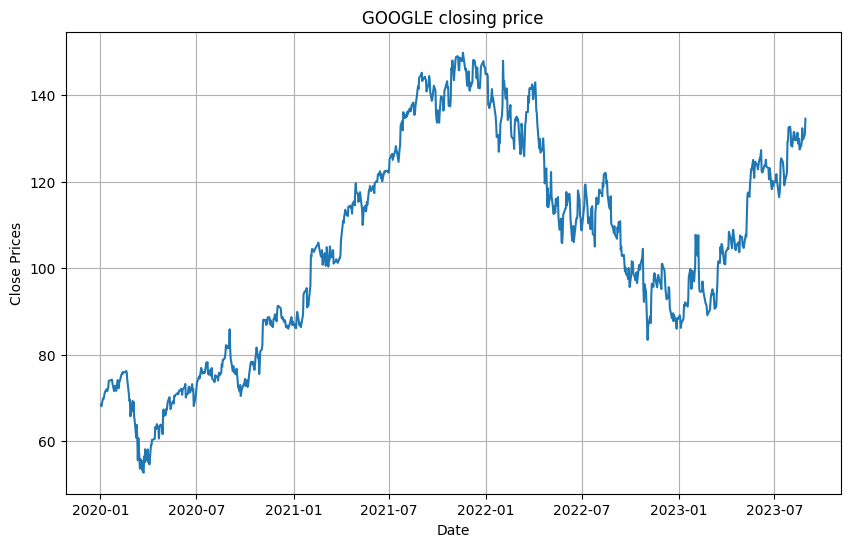

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('GOOGLE closing price')
plt.show()

In [20]:
df_close=stock_data.reset_index()['Close']

### Train Test Split

In [21]:
training_size=int(len(df_close)*0.80)
test_size=len(df_close)-training_size
print(training_size,test_size)
train_data,test_data=df_close[0:training_size],df_close[training_size:len(df_close)]

736 185


## Testing for Stationarity using Augmented Dickey Fuller test

In [22]:
#Test for stationarity
def test_stationarity(timeseries):
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
      output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(train_data)

Results of dickey fuller test
Test Statistics                 -1.465481
p-value                          0.550513
No. of lags used                 1.000000
Number of observations used    734.000000
critical value (1%)             -3.439290
critical value (5%)             -2.865486
critical value (10%)            -2.568871
dtype: float64


The Time series is non-Stationary.

In [23]:
arima_fit=pm.auto_arima(train_data,error_action='ignore',suppress_warnings=True,stepwise=False,seasonal=False)
arima_fit.summary

<bound method ARIMA.summary of ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)>

In [24]:
n_fcast1=len(test_data)
n_fcast1

185

In [25]:
arima_fcast=arima_fit.predict(n_periods=n_fcast1,return_conf_int=True,alpha=0.05)
arima_fcast

(736    101.037924
 737    101.082067
 738    101.126509
 739    101.170927
 740    101.215347
           ...    
 916    109.033254
 917    109.077674
 918    109.122094
 919    109.166514
 920    109.210934
 Length: 185, dtype: float64,
 array([[ 96.84716296, 105.22868569],
        [ 95.38455756, 106.77957733],
        [ 94.22991257, 108.02310587],
        [ 93.25584982, 109.08600502],
        [ 92.39859492, 110.03210004],
        [ 91.62536559, 110.89416921],
        [ 90.91629637, 111.69207828],
        [ 90.25830256, 112.43891195],
        [ 89.64222133, 113.14383302],
        [ 89.06134037, 113.81355383],
        [ 88.51056803, 114.45316602],
        [ 87.98593329, 115.06664062],
        [ 87.48426811, 115.65714565],
        [ 87.00299702, 116.2272566 ],
        [ 86.53999262, 116.77910085],
        [ 86.09347351, 117.31445981],
        [ 85.66193029, 117.83484288],
        [ 85.24407073, 118.3415423 ],
        [ 84.83877839, 118.83567448],
        [ 84.44508089, 119.31821184],
 

In [26]:
prediction = pd.DataFrame(arima_fcast[0], columns=['prediction'])
ci = pd.DataFrame(arima_fcast[1], columns=['lower_95', 'upper_95'])
ci.index=test_data.index
arima_fcast=pd.concat([prediction,ci],axis=1).set_index(test_data.index)
arima_fcast


,prediction,lower_95,upper_95
736,101.037924,96.847163,105.228686
737,101.082067,95.384558,106.779577
738,101.126509,94.229913,108.023106
739,101.170927,93.255850,109.086005
740,101.215347,92.398595,110.032100
...,...,...,...
916,109.033254,56.755409,161.311100
917,109.077674,56.655735,161.499614
918,109.122094,56.556456,161.687732
919,109.166514,56.457569,161.875459


## Predicting across the Test period and Visualizing

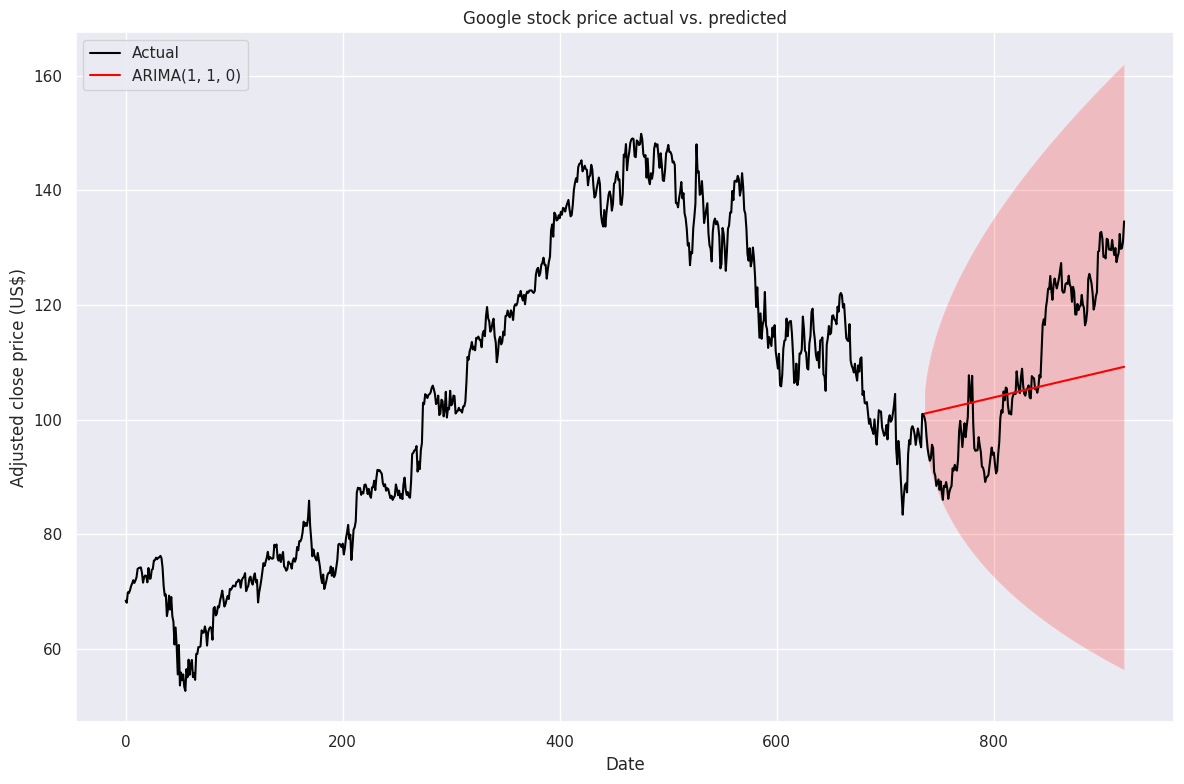

In [27]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax = sns.lineplot(data=df_close, color="black", label='Actual')
ax.plot(arima_fcast.prediction, color='red', label='ARIMA(1, 1, 0)')
ax.fill_between(arima_fcast.index, arima_fcast.lower_95, arima_fcast.upper_95,alpha= 0.2,facecolor='red')
ax.set(title="Google stock price actual vs. predicted", xlabel='Date',ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
df_close

0       68.433998
1       68.075996
2       69.890503
3       69.755501
4       70.251999
          ...    
916    132.369995
917    129.779999
918    129.880005
919    131.009995
920    134.570007
Name: Close, Length: 921, dtype: float64

In [29]:
arima_fit=pm.auto_arima(df_close,error_action='ignore',suppress_warnings=True,stepwise=False,seasonal=False)
arima_fit.summary

<bound method ARIMA.summary of ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)>

In [30]:
arima_fcast=arima_fit.predict(n_periods=30,return_conf_int=True,alpha=0.05)
arima_fcast

(921    134.432573
 922    134.356279
 923    134.323175
 924    134.320579
 925    134.339534
 926    134.373713
 927    134.418646
 928    134.471176
 929    134.529071
 930    134.590757
 931    134.655121
 932    134.721376
 933    134.788967
 934    134.857502
 935    134.926704
 936    134.996377
 937    135.066382
 938    135.136623
 939    135.207029
 940    135.277553
 941    135.348160
 942    135.418825
 943    135.489531
 944    135.560267
 945    135.631023
 946    135.701794
 947    135.772575
 948    135.843364
 949    135.914157
 950    135.984954
 dtype: float64,
 array([[130.24059831, 138.62454776],
        [128.57446442, 140.13809408],
        [127.38580387, 141.26054569],
        [126.4444985 , 142.19665948],
        [125.65668974, 143.02237898],
        [124.9730976 , 143.77432908],
        [124.36445918, 144.47283322],
        [123.81207388, 145.13027718],
        [123.30338061, 145.75476133],
        [122.82962138, 146.35189261],
        [122.38450234, 146.925739

In [31]:
prediction = pd.DataFrame(arima_fcast[0], columns=['prediction'])
ci = pd.DataFrame(arima_fcast[1], columns=['lower_95', 'upper_95'])
ci.index=pd.RangeIndex(921,951,step=1)
arima_fcast=pd.concat([prediction,ci],axis=1).set_index(pd.RangeIndex(921,951,step=1))
arima_fcast

,prediction,lower_95,upper_95
921,134.432573,130.240598,138.624548
922,134.356279,128.574464,140.138094
923,134.323175,127.385804,141.260546
924,134.320579,126.444499,142.196659
925,134.339534,125.656690,143.022379
926,134.373713,124.973098,143.774329
927,134.418646,124.364459,144.472833
928,134.471176,123.812074,145.130277
929,134.529071,123.303381,145.754761
930,134.590757,122.829621,146.351893


### Predicting Stock Price for next 30 days in the future

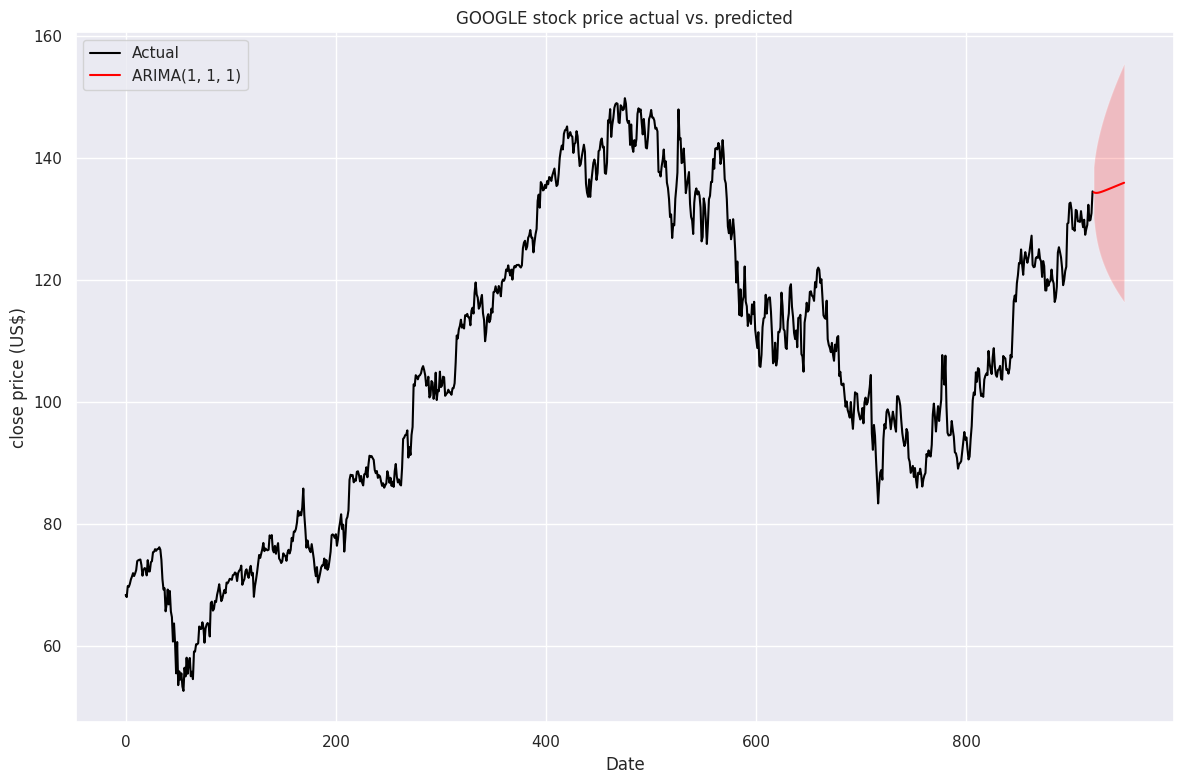

In [32]:
fig, ax = plt.subplots(1, figsize=(12, 8))
ax = sns.lineplot(data=df_close, color="black", label='Actual')
ax.plot(arima_fcast.prediction, color='red', label='ARIMA(1, 1, 1)')
ax.fill_between(arima_fcast.index, arima_fcast.lower_95, arima_fcast.upper_95,alpha= 0.2,facecolor='red')
ax.set(title="GOOGLE stock price actual vs. predicted", xlabel='Date',ylabel='close price (US$)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()